# Задача 3. Использование ALS и разреженного SVD для построения рекомендательной модели (35 баллов)

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений. 

In [120]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [121]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A_{u,m}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{u,m}=1$) и отрицательные (`Rating < 4` &mdash; $A_{u,m} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)).

In [122]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [123]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

### a. (8 баллов) Оценка ошибки аппроксимации
Напишите функцию для вычисления ошибки приближения матрицы $A$ низкоранговым приближением $USV^\top$, то есть величины $\|A - USV^\top\|_F$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - USV^\top\|_F^2$ через скалярное произведение $(X,Y)_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Имеется в виду, что ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив). 

**Решение**

Распишем скалярное произведение: $(A - USV^\top, A - USV^\top)_{F} = (A, A)_{F} - 2(A, USV^\top)_{F} + (USV^\top, USV^\top)_{F}$

$(A, A)_{F} = \mathrm{Tr}(A^\top A)$ - дано на вход

Далее пользуемся следующими рассуждениями:

а) По ортогональности столбцов $u_k$ матрицы $U$, матрица $U^\top U$ - диагональная, с элементами вида ${\|u_{k}\|_{2}}^{2}$ на главной диагонали. Аналогично для $V^\top V$

б) Диагональные матрицы коммутируют между собой

в) $\mathrm{Tr}(AB) = \mathrm{Tr}(BA)$ для перемножабельных матриц

г) $S$ - диагональная матрица, с элементами $s_k$ на главной диагонали

Из этого:

$\mathrm{Tr}(VS^\top U^\top USV^\top) = \mathrm{Tr}(V^\top VS^\top SU^\top U) = \sum_{k = 1}^{r} {\|u_{k}\|_{2}}^{2} {\|v_{k}\|_{2}}^{2} s_{k}^2$

$\mathrm{Tr}(A^\top USV^\top) = \mathrm{Tr}((A^\top U)(SV^\top))$, вычисление скобок за $O(mnr + nr)$ времени; Затем вычисление каждого диагонального элемента за O(r), и, соответственно, суммирование их всех для получения трейса за O(nr). Итого O(mnr + 2nr) = O(mnr)

In [124]:
def error(A, A_norm, U, S, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, S, VT: 2D arrays such that U @ S @ VT approximates A
        Output
            ||A - USVT||_F
    """
    tr_1 = A_norm ** 2
    
    tr_2 = 0
    X = U.T @ A
    Y = S @ VT
    for k in range(Y.shape[1]):
        tr_2 += X[:,k].T @ Y[:,k]
    
    tr_3 = 0
    for k in range(S.shape[0]):
        print()
        tr_3 += S[k,k]**2 * np.linalg.norm(U[:,k])**2 * np.linalg.norm(VT[k,:])**2
    
    return np.sqrt(tr_1 - 2*tr_2 + tr_3)

### b. (12 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции). Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

In [125]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-4, print_error=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when this relative error change is reached
            print_error: output iteration number and current error on each iteration
            
        Output
            U: m x rank numpy array with orthogonal columns
            S: rank x rank numpy array
            VT: rank x n numpy array with orthogonal rows
            errs: list of errors at each iteration
    """
    A_norm = scipy.sparse.linalg.norm(A)
    
    # initialize matrices: V should have orthogonal cols from the start afaic
    U = np.random.normal(size=(A.shape[0], rank))
    U, _ = np.linalg.qr(U)
    V = np.random.normal(size=(A.shape[1], rank))
    V, _ = np.linalg.qr(V)
    
    U_ans = None
    Vt_ans = None
    S_ans = None
    iter_num = 1
    
    errs = list()
    while len(errs) < 2 or errs[-2] - errs[-1] > tolerance:
        U = A @ V
        Q1, R1 = np.linalg.qr(U)
        V = A.T @ Q1
        Q2, R2 = np.linalg.qr(V)
        U = Q1 @ R2.T
        V = Q2
        
        # need to go from A ~ UV^T to A ~ U_ans S_ans V^T_ans
        # solution: decompose a low-rank matrix even further
        # preferrably with small shapes
        X, S, Yt = np.linalg.svd(R2.T)
        U_ans, S_ans, Vt_ans = Q1 @ X, np.diag(S), Yt @ Q2.T
        
        cur_error = error(A, A_norm, U_ans, S_ans, Vt_ans) / A_norm
        errs.append(cur_error)
        if print_error:
            print("iteration num:", iter_num, "  current error:", cur_error)
        
        iter_num += 1
    ##
    
    return U_ans, S_ans, Vt_ans, np.array(errs)

Запустим метод на матрице `A_train` и посмотрим на убывание ошибки от номера итерации. Будем использовать уже знакомый `plt.semilogy`, применённый к разнице ошибки и минимальной достигнутой ошибки, но прибавим маленькое число, чтобы не получить логарифм от нуля.

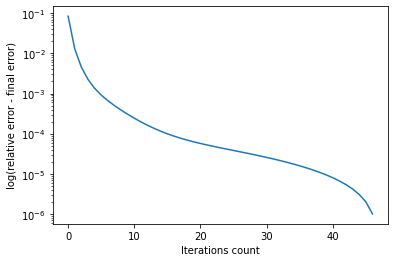

In [126]:
rank = 30
U_als, S_als, VT_als, errors_als = ALS(A_train, rank, 1e-6, print_error=False)
plt.plot(errors_als - errors_als[-1] + 1e-6)
plt.ylabel('log(relative error - final error)')
plt.xlabel('Iterations count')
_ = plt.semilogy()

Сравните ошибку приближения с той, которую даёт Sparse SVD, прокомментируйте.

In [127]:
from scipy.sparse.linalg import svds
U_svd, S_svd, VT_svd = svds(A_train, k=rank)
A_norm = sparse_norm(A_train)
svd_error = error(A_train, A_norm, U_svd, np.diag(S_svd), VT_svd) / A_norm
(errors_als[-1], svd_error, errors_als[-1] - svd_error)

(0.818190126355936, 0.8181779546719098, 1.2171684026229812e-05)

**Комментарий:** Разница всего лишь минус 5-го порядка, при том, что сами числа далеки от нуля (можно посмотреть отношение двух ошибок в ячейке ниже: наша ошибка всего на 1.5 тысячные больше "заводской"). По-моему, это очень достойно.

In [128]:
print("ALS/SparseSVD error difference: ",(errors_als[-1] / svd_error - 1) * 100, "%", sep='')

ALS/SparseSVD error difference: 0.0014876572946853628%


### c. (5 баллов) Использование рандомизированного SVD
Скопируйте из первого ДЗ (или реализуйте заново) функцию, вычисляющую рандомизированное SVD заданного ранга. Благодаря тому, что в ней используются только операции умножения матрицы `A` на небольшие матрицы слева и справа, она должна эффективно заработать для нашей разреженной матрицы `A_train`. Есть одна тонкость: если в первой домашке вы возвращали матрицу `Ar` размеров как исходная `A`, то здесь так делать нельзя по понятным причинам. Вместо этого возвращайте три матрицы $U$, $S$, $V^\top$ такие, что $A_r = USV^\top$.

In [129]:
def rand_svd(M, r, oversampling=10):
    '''
        Input
            M: m x n 2D numpy array (possibly sparse)
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(A)

        Output
            U: m x r numpy array with orthogonal columns
            S: r x r numpy array
            VT: r x n numpy array with orthogonal rows
    '''

    Omega = np.random.normal(size=(M.shape[1], r+oversampling))
    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    tmp = Q.T @ M
    W, Si, Vt = np.linalg.svd(tmp, full_matrices=False)
    U = Q @ W
    
    return U[:,:r], np.diag(Si[:r]), Vt[:r, :]

Сравните результат применения рандомизированного SVD со Sparse SVD для разных значений `oversampling` (попробуйте 10, 100, 250). Сравните по времени работы все три алгоритма на заданном ранге (30), причём возьмите `oversampling = 10` и `oversampling = 100`.

In [130]:
# TO BE FILLED
for oversampling_val in [10, 100, 250]:
    U_rand, S_rand, VT_rand = rand_svd(A_train, rank, oversampling=oversampling_val)
    rand_svd_error = error(A_train, A_norm, U_rand, S_rand, VT_rand) / A_norm
    print("oversampling =", oversampling_val)
    print("rand_svd error/sparse_svd error/difference:")
    print(rand_svd_error,"/", svd_error, "/",rand_svd_error - svd_error)
    print("****")































oversampling = 10
rand_svd error/sparse_svd error/difference:
0.8896534268669632 / 0.8181779546719098 / 0.07147547219505346
****






























oversampling = 100
rand_svd error/sparse_svd error/difference:
0.8582710335628982 / 0.8181779546719098 / 0.040093078890988454
****






























oversampling = 250
rand_svd error/sparse_svd error/difference:
0.8413953669513504 / 0.8181779546719098 / 0.02321741227944063
****


In [131]:
print("sparse_svd time:")
%timeit svds(A_train, k=rank)

print()

print("ALS_svd time:")
%timeit ALS(A_train, rank, tolerance=1e-6)

print()

for oversampling_val in [10, 100, 250]:
    print("rand_svd time, oversampling =", oversampling_val, ":")
    %timeit rand_svd(A_train, rank, oversampling=oversampling_val)
    print()

sparse_svd time:
1.49 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

ALS_svd time:







































































































































































































































































































































































































































































































































































































































































































































































































































































































































### d. (10 баллов) Построение рекомендаций
Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V^\top$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `n_recs` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`n_recs` рекомендаций, то есть `n_recs` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `known_ratings` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же.

In [150]:
def recommend(VT, known_ratings, n_recs):
    """
        Input
            VT: 2D numpy array
            known_rating: sparse batch_size x n_movies array
            n_recs: requested number of recommendations
            
        Output
            recs: batch_size x n_recs array of movies to recommend, with descending predicted rating
    """
    
    Center = np.linalg.inv(VT @ VT.T)
    A = known_ratings @ VT.T
    B = A @ Center
    C = B @ VT
    
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
    recommendation_ids = C[0,:].argsort()[-n_recs:][::-1]
    for user in range(1, C.shape[0]):
        row = np.array(C[user,:].argsort()[-n_recs:][::-1])
        recommendation_ids = np.vstack((recommendation_ids, row))
    
    
        
    return recommendation_ids

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [151]:
evaluate_model(VT_als, A_test, 10)

[10,
 10,
 10,
 10,
 10,
 10,
 4,
 10,
 2,
 10,
 10,
 10,
 10,
 10,
 9,
 6,
 10,
 10,
 10,
 10,
 10,
 5,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 8,
 10,
 10,
 3,
 4,
 10,
 0,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 0,
 10,
 10,
 10,
 10,
 10,
 7,
 10,
 10,
 1,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 3,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 1,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 1,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 5,
 10,
 7,
 10,
 1,
 1,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 0,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 1,
 10,
 10,
 10,
 10,
 10,
 0,
 10,
 10,
 5,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 7,
 10,
 10,
 10,
 3,
 10,
 10,
 10,
 10,
 1

In [136]:
from scipy.sparse import find

def evaluate_model(VT, A_test, n_recs, batch_size=500):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users
            n_recs: requested number of recommendations
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-n_recs recommendations (or n_recs if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(VT, A_test[nonempty_users[i:i + batch_size], :], n_recs + 1)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V^\top$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `n_recs`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `n_recs == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [137]:
def get_hit_rates(VT, A_test, n_recs):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users 
            n_recs: list of ints: number of top recomendations to evaluate hit rate for
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    
    """
    # TO BE FILLED
    
    return # TO BE FILLED

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [138]:
# TO BE FILLED

Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

NameError: name 'oversampling' is not defined

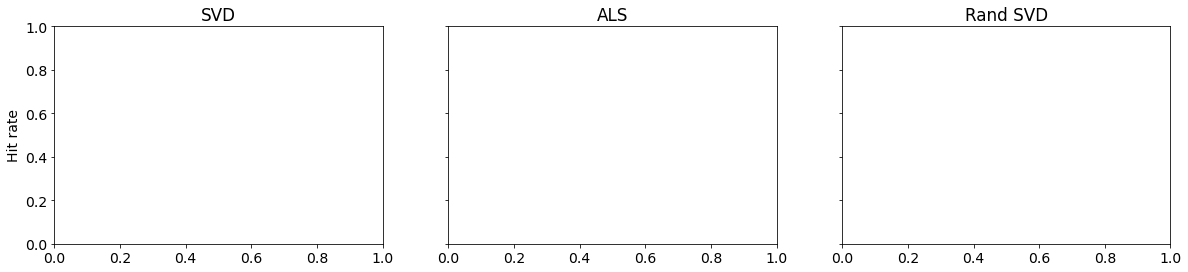

In [139]:
from scipy.sparse.linalg import svds

n_recs = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50, 75]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, _, VT_als, _ = ALS(A_train, rank)
    _, _, VT_rand = rand_svd(A_train, rank, oversampling)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(VT, A_test[:1000,:], n_recs)
        line, = ax.plot(n_recs, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

# Задача 4. Higher-order SVD (25 баллов)

2. (**8 баллов**) Напишите функцию ```full(G, U, V, W)```, возвращающую полный тензор размера $n_1\times n_2 \times n_3$ по его разложению Таккера.

In [ ]:
def full(G, U, V, W):
    """
        Input
            G: 3D numpy array - Tucker core of size (r1, r2, r3)
            U: 2D numpy array - first Tucker factor of size (n1, r1)
            V: 2D numpy array - second Tucker factor of size (n2, r2)
            W: 2D numpy array - third Tucker factor of size (n3, r3)

        Output
            A: 3D numpy array of size (n1, n2, n3)
    """
    
    A = np.zeros((U.shape[0], V.shape[0], W.shape[0]))
    
    R1, R2, R3 = G.shape[0], G.shape[1], G.shape[2]
    for a in range(R1):
        for b in range(R2):
            for c in range(R3):
                x = U[:,a]
                y = V[:,b]
                z = W[:,c]
                A += np.outer(x,np.outer(y,z)).reshape(x.shape[0],y.shape[0],z.shape[0])
                # внешнее произведение честно заимствовано отсюда:
                # https://stackoverflow.com/questions/43148829/how-to-3-way-outer-product-in-numpy/43148960
        #print("full_cycles: ", a*R2*R3)
        
    
    return A

1. (**14 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного трехмерного массива $A\in\mathbb{R}^{n_1\times n_2 \times n_3}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора.

**Объяснение получение матрицизаций по моде p** (для себя, чтобы я не запутался):

A_1: a_ijk -> a_ijk, k матриц {a_ij} приклеены друг к другу горизонтально

A_2: a_ijk -> a_jik, k матриц {a_ji} = {a_ij}^T приклеены горизонтально

A_3: a_ijk -> a_kij, j матриц {a_ki} приклеены горизонтально

In [ ]:
def get_mode_p_unfold(A, p=0):
    inds = [p]
    inds.extend(range(p))
    inds.extend(range(p + 1, len(A.shape)))
    #print(inds)
    At = np.transpose(A, inds)
    return At.reshape(At.shape[0], At.shape[1] * At.shape[2])

def hosvd(A, eps):
    """
        Input
            A: 3D numpy array
            eps: accuracy of Tucker approximation

        Output
            G: 3D numpy array - Tucker core
            U: 2D numpy array - first Tucker factor with orthogonal columns
            V: 2D numpy array - second Tucker factor with orthogonal columns
            W: 2D numpy array - third Tucker factor with orthogonal columns
    """
    
    # so we get desired eps
    eps /= np.sqrt(3)
    
    # for each k:
    # find A_k := k-mode unfold, find its SVD,
    # search for minimial r_k
    # 
    unfolds = [get_mode_p_unfold(A, p) for p in range(len(A.shape))]
    print("unfolds calculated")
    Tucker_rank = list()
    Factors = list()
    for unfold in unfolds:
        U, S, VT = np.linalg.svd(unfold, full_matrices=False)
        close_enough = False
        r_k = 0
        while not close_enough and r_k + 1 < U.shape[1]:
            r_k += 1
            U_k = U[:, :r_k]
            f_dist = np.linalg.norm(unfold - U_k @ U_k.T @ unfold)  # TODO не пересчитывать норму каждый раз?
                                                                    # Впрочем, она довольно быстро считается
            #f_dist = np.sqrt((S[r_k+1:]**2).sum())  # фробениусова норма = корень из суммы квадратов сингулярных чисел
                                                    # чего добру пропадать
            #print(f_dist)
            if f_dist <= eps or r_k + 1 == U.shape[1]:
                close_enough = True
                Tucker_rank.append(r_k)
                Factors.append(U_k)
                print("factors solved:", len(Factors))
                print("************")
    
    #print("found Tucker Rank:", Tucker_rank)
    
    core = full(A, Factors[0].T, Factors[1].T, Factors[2].T)
    
    return core, Factors[0], Factors[1], Factors[2]

3. (**3 балла**) Примените функцию ```hosvd``` к тензору размера $100 \times 150 \times 200$ с элементами
$$
    a_{ijk} = \frac{1}{i + j + k - 2}
$$
для малорангового приближения с точностью $10^{-6}$. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```full```).

In [ ]:
n1 = 100
n2 = 150
n3 = 200
grand_finale = np.zeros((n1, n2, n3))
print(grand_finale.shape)
for i in range(n1):
    for j in range(n2):
        for k in range(n3):
            grand_finale[i,j,k] = 1 / (i + j + k + 1)  # index from 0

print("tensor initialized")

G, U, V, W = hosvd(grand_finale, 1e-6)

In [ ]:
print("Tucker Rank:", G.shape[0], G.shape[1], G.shape[2])
g_norm = np.linalg.norm(grand_finale)
print("Relative error:", np.linalg.norm(grand_finale - full(G, U, V, W)) / g_norm)

# Задача 5 (бонусная). Метод крестовой аппроксимации

Реализуйте метод крестовой аппроксимации описанный в лекции (с упомянутым критерием остановки, включающим вычисление ошибки по точности аппроксимации новых элементов матрицы текущей крестовой аппроксимации и ```nsamples``` случайным элементам). Убедитесь, что вы не формируете полные матрицы размеров $m\times n$: алгоритм должен работать с асимптотической сложностью $\mathcal{O}((m+n)r^2)$, где $r$ является количеством выбранных столбцов (строк).

In [ ]:
def cross_approximation(func, tol, maxrank=100, nsamples=50, ind0=0):
    """
        Input
            func(i, j): function that returns matrix element in position i, j
            tol: desired relative error of the approximation
            maxrank: algorithm stops after reaching maxrank of columns
            nsamples: number of random samples used to check error of the current approximation
            ind0: initial guess for a ``good'' column

        Output
            U and V: 2D numpy arrays of sizes (m, r) and (n, r) resp.,
                     such that UV^T approximates A with tol
    """
    # TO BE FILLED
    return # TO BE FILLED

Запустите алгоритм на приближении с относительной точностью $10^{-5}$ матрицы Гильберта размера $10^6 \times 10^6$. 

In [ ]:
# TO BE FILLED